In [1]:
import torch
import torchvision
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
import shutil
from pathlib import Path
import random
from ultralytics import YOLO
import warnings
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
warnings.filterwarnings('ignore')

print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device:", torch.cuda.get_device_name(0))

Python: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:42:04) [MSC v.1943 64 bit (AMD64)]
PyTorch: 2.8.0+cpu
CUDA Available: False


In [2]:

import kaggle
from zipfile import ZipFile
import os

def setup_dataset():
    
    
    dataset_dir = Path("wild_animal_dataset")
    dataset_dir.mkdir(exist_ok=True)
    
    print("Downloading Wild Animal Dataset from Kaggle...")
    try:
        kaggle.api.dataset_download_files(
            'chandrug/wildanimaldataset', 
            path=str(dataset_dir), 
            unzip=True
        )
        print("Dataset downloaded successfully")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Please ensure kaggle.json is in ~/.kaggle/ directory")
        print("Or manually download the dataset from Kaggle")
        return None
    
    print("\nDataset contents:")
    for root, dirs, files in os.walk(dataset_dir):
        level = root.replace(str(dataset_dir), '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]: 
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")
    
    return dataset_dir

dataset_path = setup_dataset()


Dataset URL: https://www.kaggle.com/datasets/chandrug/wildanimaldataset
Dataset downloaded successfully

Dataset contents:
wild_animal_dataset/
  animal/
    bear_png/
      00000000.jpg
      00000001.jpg
      00000002.jpg
      00000003.jpg
      00000005.jpg
      ... and 47 more files
    chinkara/
      14.jpg
      c1.jpg
      p10.jpg
      p11.jpg
      p12.jpg
      ... and 56 more files
    elephant/
      0936202000e0ab96a4960925b37fdcc1-700.jpg
      11878674-indian-elephant.jpg
      1200px-African_Elephant_(Loxodonta_africana)_male_(17289351322).jpg
      1200px-Asiatic_Elephant_Kabini.jpg
      1200px-Borobudur-Temple-Park_Elephant-cage-01.jpg
      ... and 57 more files
    lion/
      0001.jpg
      0002.jpg
      0003.jpg
      0004.jpg
      0005.jpg
      ... and 55 more files
    peacock/
      001.jpg
      002.jpg
      003.jpg
      004.jpg
      005.jpg
      ... and 55 more files
    pig/
      p1.jpg
      p10.jpg
      p11.jpg
      p12.jpg
      p13.jpg
  

In [3]:
def explore_dataset(dataset_path):
    
    if not dataset_path or not dataset_path.exists():
        print("Dataset path not found")
        return
    

    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = []
    
    for ext in image_extensions:
        image_files.extend(list(dataset_path.rglob(f"*{ext}")))
        image_files.extend(list(dataset_path.rglob(f"*{ext.upper()}")))
    
    print(f"Total images found: {len(image_files)}")
    

    folders = [f for f in dataset_path.iterdir() if f.is_dir()]
    print(f"\nFolders found: {len(folders)}")
    
    class_counts = {}
    for folder in folders:
        if folder.is_dir():
            folder_images = []
            for ext in image_extensions:
                folder_images.extend(list(folder.glob(f"*{ext}")))
                folder_images.extend(list(folder.glob(f"*{ext.upper()}")))
            
            class_counts[folder.name] = len(folder_images)
            print(f"  {folder.name}: {len(folder_images)} images")
    
    return class_counts, image_files


if dataset_path:
    class_counts, all_images = explore_dataset(dataset_path)


Total images found: 956

Folders found: 1
  animal: 0 images


In [4]:

animal_classes = [
    'bear', 'bird', 'cat', 'cow', 'deer', 'dog', 'elephant', 
    'fox', 'giraffe', 'goat', 'horse', 'lion', 'monkey', 
    'rabbit', 'sheep', 'tiger', 'wolf', 'zebra'
]

carnivorous_animals = {
    'bear', 'cat', 'dog', 'fox', 'lion', 'tiger', 'wolf'
}

class_to_id = {class_name: idx for idx, class_name in enumerate(animal_classes)}
id_to_class = {idx: class_name for idx, class_name in enumerate(animal_classes)}

carnivorous_ids = {class_to_id[animal] for animal in carnivorous_animals if animal in class_to_id}

print("Animal Classes:")
for i, animal in enumerate(animal_classes):
    carnivore_status = "CARNIVORE" if animal in carnivorous_animals else "HERBIVORE"
    print(f"  {i}: {animal} - {carnivore_status}")

print(f"\nCarnivorous class IDs: {carnivorous_ids}")


Animal Classes:
  0: bear - CARNIVORE
  1: bird - HERBIVORE
  2: cat - CARNIVORE
  3: cow - HERBIVORE
  4: deer - HERBIVORE
  5: dog - CARNIVORE
  6: elephant - HERBIVORE
  7: fox - CARNIVORE
  8: giraffe - HERBIVORE
  9: goat - HERBIVORE
  10: horse - HERBIVORE
  11: lion - CARNIVORE
  12: monkey - HERBIVORE
  13: rabbit - HERBIVORE
  14: sheep - HERBIVORE
  15: tiger - CARNIVORE
  16: wolf - CARNIVORE
  17: zebra - HERBIVORE

Carnivorous class IDs: {0, 2, 5, 7, 11, 15, 16}


In [5]:
def create_yolo_dataset(dataset_path, output_path, train_split=0.8):
    
    if not dataset_path or not dataset_path.exists():
        print("Dataset path not found!")
        return None
    
    output_path = Path(output_path)
    output_path.mkdir(exist_ok=True)
    
    train_images = output_path / "images" / "train"
    val_images = output_path / "images" / "val"
    train_labels = output_path / "labels" / "train"
    val_labels = output_path / "labels" / "val"
    
    for dir_path in [train_images, val_images, train_labels, val_labels]:
        dir_path.mkdir(parents=True, exist_ok=True)
    
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    all_image_files = []
    
    for ext in image_extensions:
        all_image_files.extend(list(dataset_path.rglob(f"*{ext}")))
        all_image_files.extend(list(dataset_path.rglob(f"*{ext.upper()}")))
    
    print(f"Found {len(all_image_files)} total images")
    
    class_groups = {}
    
    for img_file in all_image_files:
        parent_folder = img_file.parent.name.lower()
        
        if parent_folder in ['wild_animal_dataset', 'images', 'data']:
            continue
        
        class_mapping = {
            'bears': 'bear', 'bear': 'bear',
            'birds': 'bird', 'bird': 'bird',
            'cats': 'cat', 'cat': 'cat',
            'cows': 'cow', 'cow': 'cow',
            'deer': 'deer', 'deers': 'deer',
            'dogs': 'dog', 'dog': 'dog',
            'elephants': 'elephant', 'elephant': 'elephant',
            'foxes': 'fox', 'fox': 'fox',
            'giraffes': 'giraffe', 'giraffe': 'giraffe',
            'goats': 'goat', 'goat': 'goat',
            'horses': 'horse', 'horse': 'horse',
            'lions': 'lion', 'lion': 'lion',
            'monkeys': 'monkey', 'monkey': 'monkey',
            'rabbits': 'rabbit', 'rabbit': 'rabbit',
            'sheep': 'sheep', 'sheeps': 'sheep',
            'tigers': 'tiger', 'tiger': 'tiger',
            'wolves': 'wolf', 'wolf': 'wolf',
            'zebras': 'zebra', 'zebra': 'zebra'
        }
        
        class_name = None
        for key, value in class_mapping.items():
            if key in parent_folder:
                class_name = value
                break
        
        if not class_name:
            class_name = parent_folder
            print(f"Using folder name as class: {class_name}")
        
        if class_name not in class_groups:
            class_groups[class_name] = []
        class_groups[class_name].append(img_file)
    
    print(f"Found classes: {list(class_groups.keys())}")
    
    found_classes = list(class_groups.keys())
    if found_classes:
        global animal_classes, class_to_id, id_to_class, carnivorous_ids
        animal_classes = sorted(found_classes)
        class_to_id = {class_name: idx for idx, class_name in enumerate(animal_classes)}
        id_to_class = {idx: class_name for idx, class_name in enumerate(animal_classes)}
        
        carnivorous_animals_updated = {
            animal for animal in carnivorous_animals if animal in animal_classes
        }
        carnivorous_ids = {class_to_id[animal] for animal in carnivorous_animals_updated}
        
        print(f"Updated animal classes: {animal_classes}")
        print(f"Carnivorous animals found: {carnivorous_animals_updated}")
    
    
    all_files = []
    for class_name, image_files in class_groups.items():
        if class_name not in class_to_id:
            continue
            
        class_id = class_to_id[class_name]
        print(f"Processing {class_name}: {len(image_files)} images")
        
        for img_file in image_files:
            all_files.append((img_file, class_id, class_name))
    
    if not all_files:
        print(" No valid images found! Check dataset structure.")
        return None
    
    random.shuffle(all_files)
    split_idx = int(len(all_files) * train_split)
    train_files = all_files[:split_idx]
    val_files = all_files[split_idx:]
    
    def process_split(files, img_dir, label_dir, split_name):
        print(f"Processing {split_name} split: {len(files)} files")
        
        processed = 0
        for idx, (img_file, class_id, class_name) in enumerate(files):
            try:
                img = cv2.imread(str(img_file))
                if img is None:
                    continue
                    
                h, w = img.shape[:2]
                
                new_img_name = f"{class_name}_{idx:06d}.jpg"
                new_img_path = img_dir / new_img_name
                cv2.imwrite(str(new_img_path), img)
                
               
                label_content = f"{class_id} 0.5 0.5 0.8 0.8\n"
                
                label_file = label_dir / f"{new_img_name.replace('.jpg', '.txt')}"
                with open(label_file, 'w') as f:
                    f.write(label_content)
                
                processed += 1
                    
            except Exception as e:
                print(f"Error processing {img_file}: {e}")
                continue
        
        print(f" Successfully processed {processed} images for {split_name}")
        return processed
    
    train_count = process_split(train_files, train_images, train_labels, "train")
    val_count = process_split(val_files, val_images, val_labels, "validation")
    
    if train_count == 0 and val_count == 0:
        print(" No images were processed successfully!")
        return None
    
    data_yaml = {
        'path': str(output_path.absolute()),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(animal_classes),
        'names': animal_classes
    }
    
    import yaml
    with open(output_path / "data.yaml", 'w') as f:
        yaml.dump(data_yaml, f, default_flow_style=False)
    
    print(f" YOLO dataset created at: {output_path}")
    print(f"  Train images: {train_count}")
    print(f"  Val images: {val_count}")
    print(f"  Classes: {len(animal_classes)}")
    
    return output_path

if dataset_path:
    yolo_dataset_path = create_yolo_dataset(dataset_path, "yolo_animal_dataset")


Found 956 total images
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder name as class: chinkara
Using folder na

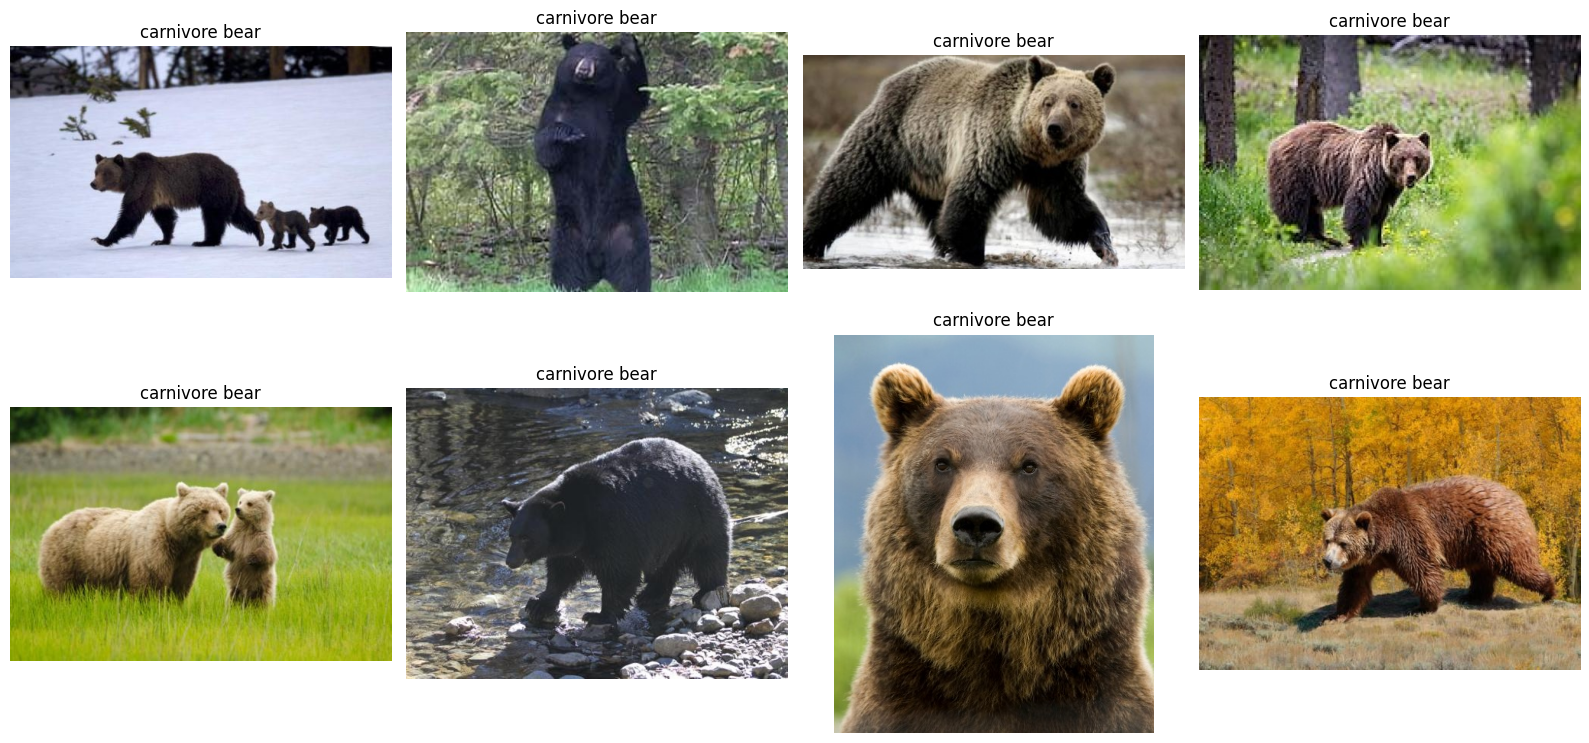

In [6]:
def visualize_samples(yolo_path, num_samples=8):
    
    train_img_dir = yolo_path / "images" / "train"
    train_label_dir = yolo_path / "labels" / "train"
    
    img_files = list(train_img_dir.glob("*.jpg"))[:num_samples]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, img_file in enumerate(img_files):
        if i >= num_samples:
            break
            
        
        img = cv2.imread(str(img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label_file = train_label_dir / f"{img_file.stem}.txt"
        
        title = img_file.stem
        if label_file.exists():
            with open(label_file, 'r') as f:
                label_data = f.readline().strip().split()
                if label_data:
                
                    class_id = int(label_data[0])  
                    class_name = id_to_class[class_id]
                    is_carnivore = class_name in carnivorous_animals
                    color = "carnivore" if is_carnivore else "herbivore"
                    title = f"{color} {class_name}"
        
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


if 'yolo_dataset_path' in locals():
    visualize_samples(yolo_dataset_path)


In [7]:
def setup_yolo_model():
    
    model_size = 'n'  
    model = YOLO(f'yolov8{model_size}.pt')
    
    print(f" Loaded YOLOv8{model_size} model")
    print(f" Model parameters: {sum(p.numel() for p in model.model.parameters()):,}")
    
    return model

model = setup_yolo_model()


 Loaded YOLOv8n model
 Model parameters: 3,157,200


In [ ]:
def train_animal_detection_model(model, data_yaml_path, epochs=100):    
    training_args = {
        'data': str(data_yaml_path),
        'epochs': epochs,
        'imgsz': 640,
        'batch': 16,
        'name': 'animal_detection_v1',
        'project': 'runs/detect',
        'optimizer': 'AdamW',
        'lr0': 0.01,
        'weight_decay': 0.0005,
        'warmup_epochs': 3,
        'patience': 20,
        'save_period': 10,
        'device': 0 if torch.cuda.is_available() else 'cpu',
        'workers': 4,
        'exist_ok': True,
        'pretrained': True,
        'verbose': True
    }
    
    print("Starting training with parameters:")
    for key, value in training_args.items():
        print(f"  {key}: {value}")
    
    results = model.train(**training_args)
    
    print(" Training completed!")
    return results

if 'yolo_dataset_path' in locals() and 'model' in locals():
    data_yaml_file = yolo_dataset_path / "data.yaml"
    training_results = train_animal_detection_model(model, data_yaml_file, epochs=50)

Starting training with parameters:
  data: yolo_animal_dataset\data.yaml
  epochs: 50
  imgsz: 640
  batch: 16
  name: animal_detection_v1
  project: runs/detect
  optimizer: AdamW
  lr0: 0.01
  weight_decay: 0.0005
  warmup_epochs: 3
  patience: 20
  save_period: 10
  device: cpu
  workers: 4
  exist_ok: True
  pretrained: True
  verbose: True
New https://pypi.org/project/ultralytics/8.3.186 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.184  Python-3.10.18 torch-2.8.0+cpu CPU (AMD Ryzen 5 7235HS)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_animal_dataset\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript

train: Scanning C:\Users\sarva\Emotion_detection-main\animal_detection\yolo_animal_dataset\labels\train... 2557 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2557/2557 [00:09<00:00, 281.94it/s]


train: New cache created: C:\Users\sarva\Emotion_detection-main\animal_detection\yolo_animal_dataset\labels\train.cache
val: Fast image access  (ping: 0.10.0 ms, read: 2.20.6 MB/s, size: 25.0 KB)


val: Scanning C:\Users\sarva\Emotion_detection-main\animal_detection\yolo_animal_dataset\labels\val... 634 images, 0 backgrounds, 0 corrupt: 100%|██████████| 634/634 [00:02<00:00, 285.31it/s]


val: New cache created: C:\Users\sarva\Emotion_detection-main\animal_detection\yolo_animal_dataset\labels\val.cache
Plotting labels to runs\detect\animal_detection_v1\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\animal_detection_v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G     0.9339       2.07      1.377         37        640: 100%|██████████| 160/160 [17:02<00:00,  6.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [01:04<00:00,  3.24s/it]

                   all        634        634      0.151       0.59      0.217      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.8252      1.749      1.276         30        640: 100%|██████████| 160/160 [16:09<00:00,  6.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [01:01<00:00,  3.07s/it]

                   all        634        634      0.809     0.0944     0.0723     0.0427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.7846       1.64      1.244         33        640: 100%|██████████| 160/160 [1:19:15<00:00, 29.72s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]

                   all        634        634      0.258       0.66      0.404      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.7182      1.556      1.198         38        640: 100%|██████████| 160/160 [18:09<00:00,  6.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]

                   all        634        634       0.23      0.606      0.358       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.7049      1.483       1.19         39        640: 100%|██████████| 160/160 [17:41<00:00,  6.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [01:05<00:00,  3.29s/it]

                   all        634        634      0.273      0.747      0.476      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.6649      1.427      1.164         40        640: 100%|██████████| 160/160 [15:55<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:50<00:00,  2.52s/it]

                   all        634        634      0.192      0.337      0.219      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      0.623      1.389      1.145         39        640: 100%|██████████| 160/160 [12:58<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]

                   all        634        634      0.364       0.56       0.48      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.6097      1.358      1.132         40        640: 100%|██████████| 160/160 [12:52<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]

                   all        634        634      0.589      0.443      0.466      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.5965      1.291      1.122         33        640: 100%|██████████| 160/160 [12:35<00:00,  4.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]

                   all        634        634      0.483      0.746      0.578      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.5682      1.273      1.102         41        640: 100%|██████████| 160/160 [12:34<00:00,  4.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]

                   all        634        634      0.348      0.737      0.552      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.5798      1.272      1.107         34        640: 100%|██████████| 160/160 [14:29<00:00,  5.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:58<00:00,  2.92s/it]

                   all        634        634      0.312      0.626      0.446      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.5642       1.21      1.097         36        640: 100%|██████████| 160/160 [14:16<00:00,  5.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]

                   all        634        634      0.493       0.79      0.693      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.5556       1.21      1.092         33        640: 100%|██████████| 160/160 [13:59<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:51<00:00,  2.57s/it]

                   all        634        634      0.548      0.764      0.657      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.5392      1.142      1.083         38        640: 100%|██████████| 160/160 [12:56<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]

                   all        634        634       0.58      0.804      0.748      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.5338      1.122       1.08         32        640: 100%|██████████| 160/160 [12:39<00:00,  4.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:51<00:00,  2.58s/it]

                   all        634        634      0.421      0.551      0.502      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G       0.52      1.102      1.077         47        640: 100%|██████████| 160/160 [13:55<00:00,  5.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:52<00:00,  2.62s/it]

                   all        634        634      0.485      0.667      0.649      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.5089      1.086      1.075         40        640: 100%|██████████| 160/160 [16:15<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [01:02<00:00,  3.13s/it]

                   all        634        634      0.556       0.82      0.773      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      0.502       1.08      1.073         39        640: 100%|██████████| 160/160 [18:08<00:00,  6.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [01:07<00:00,  3.40s/it]

                   all        634        634      0.564      0.799      0.689      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.5092       1.01      1.072         35        640: 100%|██████████| 160/160 [17:54<00:00,  6.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]

                   all        634        634      0.597      0.667      0.714      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.5026      1.018      1.068         39        640: 100%|██████████| 160/160 [15:07<00:00,  5.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:51<00:00,  2.58s/it]

                   all        634        634      0.693      0.844      0.864      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.4956     0.9333      1.063         41        640: 100%|██████████| 160/160 [14:01<00:00,  5.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]

                   all        634        634      0.619      0.831      0.861      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.4792     0.8774      1.053         36        640: 100%|██████████| 160/160 [14:40<00:00,  5.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:57<00:00,  2.88s/it]

                   all        634        634       0.87        0.8      0.904      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.4891     0.8868      1.058         39        640: 100%|██████████| 160/160 [14:37<00:00,  5.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:56<00:00,  2.82s/it]

                   all        634        634      0.764      0.799      0.857      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.4646     0.8713      1.043         35        640: 100%|██████████| 160/160 [14:12<00:00,  5.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]

                   all        634        634      0.852      0.867      0.946      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.4524     0.8617      1.052         33        640:  53%|█████▎    | 85/160 [07:23<07:26,  5.96s/it]